# Calculating daily diffuse PAR using Spitter's relationship

## 1. Read some example data
Read some weather data from a TMY3 file and calculate the solar position

In [4]:
import pvlib
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import AutoDateLocator, ConciseDateFormatter
from pathlib import Path

# Datafile found in the pvlib distibution
DATA_FILE = Path(pvlib.__path__[0]).joinpath("data", "723170TYA.CSV")

tmy, metadata = pvlib.iotools.read_tmy3(
    DATA_FILE, coerce_year=2002, map_variables=True
) # remaining columns are not needed
tmy = tmy["2002-09-06":"2002-09-21"] # select some days

solar_position = pvlib.solarposition.get_solarposition(
    # TMY timestamp is at end of hour, so shift to center of interval
    tmy.index.shift(freq="-30T"),
    latitude=metadata["latitude"],
    longitude=metadata["longitude"],
    altitude=metadata["altitude"],
    pressure=tmy["pressure"] * 100, # convert from millibar to Pa
    temperature=tmy["temp_air"],
)
solar_position.index = tmy.index # reset index to end of the hour

/var/folders/77/g2hd69jj59gc5rvfpcltwrxm0000gn/T/ipykernel_89861/53880442.py:17: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  tmy.index.shift(freq="-30T"),


## 2. Calculate daily value
The daily average solar zenith angle and the daily diffuse fraction of broadband insolation are calculated as follows

In [5]:
daily_solar_zenith = solar_position["zenith"].resample("D").mean()
# integration over the day with a time step of 1 hour
daily_tmy = tmy[["ghi", "dhi"]].resample("D").sum() * 1
daily_tmy["diffuse_fraction"] = daily_tmy["dhi"] / daily_tmy["ghi"]

## 3. Calculate Photosynthetically Active Radiation
The total PAR can be approximated as 0.50 times the broadband horizontal insolation (integral of GHI) for an average solar elevation higher that 10°.

In [6]:
par = pd.DataFrame({"total": 0.50 * daily_tmy["ghi"]}, index=daily_tmy.index)
if daily_solar_zenith.min() < 10:
    raise ValueError(
        "The total PAR can't be assumed to be half the broadband insolation "
        + "for average zenith angles lower than 10°."
    )

# Calculate broadband insolation diffuse fraction, input of the Spitter's model
daily_tmy["diffuse_fraction"] = daily_tmy["dhi"] / daily_tmy["ghi"]

# Calculate diffuse PAR fraction using Spitter's relationship
par["diffuse_fraction"] = pvlib.irradiance.diffuse_par_spitters(
    solar_position["zenith"], daily_tmy["diffuse_fraction"]
)

# Finally, calculate the diffuse PAR
par["diffuse"] = par["total"] * par["diffuse_fraction"]

## 4. Plot the results
insolation on left axis, diffuse fraction on right axis

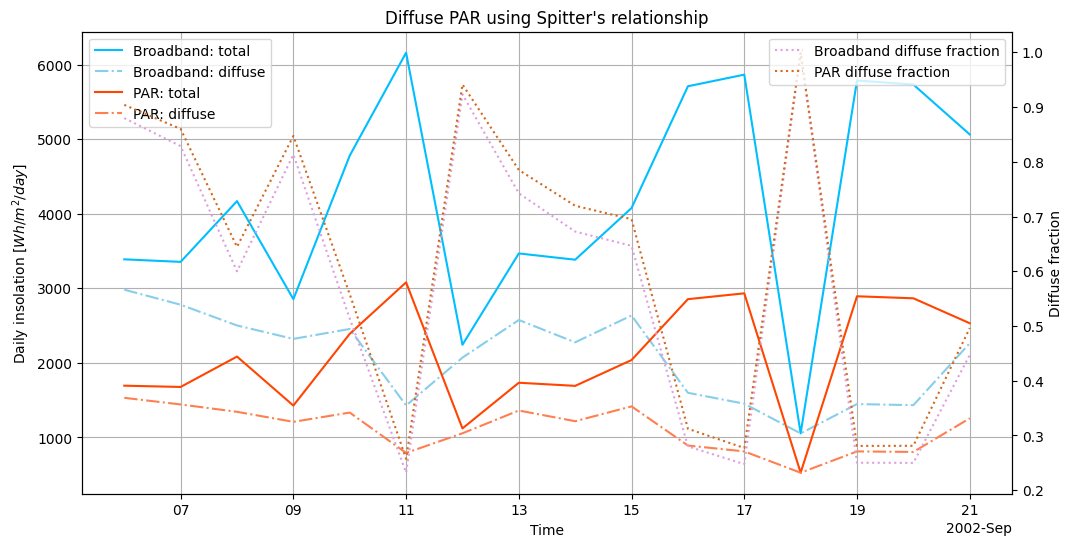

In [7]:
fig, ax_l = plt.subplots(figsize=(12, 6))
ax_l.set(
    xlabel="Time",
    ylabel="Daily insolation $[Wh/m^2/day]$",
    title="Diffuse PAR using Spitter's relationship",
)
ax_l.xaxis.set_major_formatter(
    ConciseDateFormatter(AutoDateLocator(), tz=daily_tmy.index.tz)
)
ax_l.plot(
    daily_tmy.index,
    daily_tmy["ghi"],
    label="Broadband: total",
    color="deepskyblue",
)
ax_l.plot(
    daily_tmy.index,
    daily_tmy["dhi"],
    label="Broadband: diffuse",
    color="skyblue",
    linestyle="-.",
)
ax_l.plot(daily_tmy.index, par["total"], label="PAR: total", color="orangered")
ax_l.plot(
    daily_tmy.index,
    par["diffuse"],
    label="PAR: diffuse",
    color="coral",
    linestyle="-.",
)
ax_l.grid()
ax_l.legend(loc="upper left")

ax_r = ax_l.twinx()
ax_r.set(ylabel="Diffuse fraction")
ax_r.plot(
    daily_tmy.index,
    daily_tmy["diffuse_fraction"],
    label="Broadband diffuse fraction",
    color="plum",
    linestyle=":",
)
ax_r.plot(
    daily_tmy.index,
    par["diffuse_fraction"],
    label="PAR diffuse fraction",
    color="chocolate",
    linestyle=":",
)
ax_r.legend(loc="upper right")

plt.show()